In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier

In [2]:
df = pd.read_csv('cleaned_data.csv')

In [3]:
df

,sms,label
0,"['ذهاب', 'جورونج', 'نقط', 'مجنو', 'استفاد', 'ب...",0
1,"['طيب', 'نكت', 'لار']",0
2,"['دخول', 'مجا', '٢', 'كاس', 'اتحاد', 'نهاء', '...",1
3,"['اقول', 'وقت', 'مبكر', 'هور']",0
4,"['ناه', 'اعتقد', 'جو', 'اوسف', 'عيش', 'حول', '...",0
...,...,...
5108,"['مر', '٢', 'اتصل', '٧٥٠', 'جايز', '٢', 'مطالب...",1
5109,"['ü', 'اذهب', 'متنزه', 'منزل']",0
5110,['يقترح'],0
5111,"['رجل', 'كلب', 'يتصرف', 'معرف', 'فايد', 'شراء'...",0


In [4]:
pd.set_option('display.max_colwidth', None)


In [5]:
def tfidf_features(X_train, X_test, vectorizer_path):
    """Performs TF-IDF transformation and dumps the model."""
    
    # Train a vectorizer on X_train data.
    # Transform X_train and X_test data.
    
    # Pickle the trained vectorizer to 'vectorizer_path'
    # Don't forget to open the file in writing bytes mode.
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2), token_pattern='(\S+)')
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
        
    return X_train, X_test

In [6]:
print(f"the dataframe shape: {df.shape}")
df.head()

the dataframe shape: (5113, 2)


,sms,label
0,"['ذهاب', 'جورونج', 'نقط', 'مجنو', 'استفاد', 'بوج', 'عالم', 'عظيم', 'بوف', 'سينم', 'حصل', 'امور', 'وات']",0
1,"['طيب', 'نكت', 'لار']",0
2,"['دخول', 'مجا', '٢', 'كاس', 'اتحاد', 'نهاء', '٢1', '٢005', '871٢1', '0845٢81007518']",1
3,"['اقول', 'وقت', 'مبكر', 'هور']",0
4,"['ناه', 'اعتقد', 'جو', 'اوسف', 'عيش', 'حول', 'رغم']",0


Number of dialect classes: 2


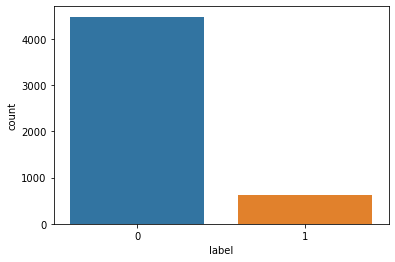

In [7]:
counts = df.label.value_counts()
print(f"Number of dialect classes: {df.label.nunique()}")
counts_df = pd.DataFrame(counts.to_dict().items(), columns=["label", "count"])
sns.barplot(data = counts_df, x="label", y="count", order=counts_df['label']);

In [8]:
X = df["sms"].values.astype('U') # You need to convert the dtype object to unicode for using tfidf_vectorizer
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify= y) ######### YOUR CODE HERE ##########
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))

X_train_tfidf, X_test_tfidf = tfidf_features(X_train, X_test, "Models/tfidf_vectorizer.pkl")

Train size = 3067, test size = 2046


In [9]:
(unique, counts) = np.unique(y_train, return_counts=True)
#cw_dict = dict(zip(unique, np.around(1/counts *counts.max(),3)))

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

#class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#class_weight = dict(enumerate(class_weights))
#print(class_weight)

#class_weight = cw_dict
#print(class_weight)

In [10]:
def plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):
    print(f"-------------------------- [{modelname}] --------------------------")
    # check train accuracy
    y_train_pred = model.predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Train accuracy = {}'.format(train_accuracy))

    # Check test accuracy.
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Test accuracy = {}'.format(test_accuracy))

    ## Show results
    list_names = list(model.classes_)
    print(classification_report(y_test, y_test_pred))
    
    fig, ax = plt.subplots(1,2,figsize= (30,15))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[0]);
    ax[0].set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[0].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[0].set_ylabel('Actual dialect',font ={'weight' : 'bold'})

    ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[1]);
    ax[1].set_title(f"[{modelname}]Train Confusion Matrix\nf1_score: {f1_score(y_train, y_train_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[1].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[1].set_ylabel('Actual dialect',font ={'weight' : 'bold'})
    plt.savefig("Models/"+modelname+'_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    with open("Models/"+ modelname + ".pkl", 'wb') as f:
        pickle.dump(model, f)


In [11]:
'''def plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):
    print(f"-------------------------- [{modelname}] --------------------------")
    # check train accuracy
    y_train_pred = model.predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Train accuracy = {}'.format(train_accuracy))

    # Check test accuracy.
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Test accuracy = {}'.format(test_accuracy))

    ## Show results
    list_names = list(model.classes_)
    print(classification_report(y_test, y_test_pred))
    
    fig, ax = plt.subplots(1,2,figsize= (30,15))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[0]);
    ax[0].set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[0].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[0].set_ylabel('Actual dialect',font ={'weight' : 'bold'})

    ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[1]);
    ax[1].set_title(f"[{modelname}]Train Confusion Matrix\nf1_score: {f1_score(y_train, y_train_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[1].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[1].set_ylabel('Actual dialect',font ={'weight' : 'bold'})
    plt.savefig("Models/"+modelname+'_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    with open("Models/"+ modelname + ".pkl", 'wb') as f:
        pickle.dump(model, f)
'''

'def plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):\n    print(f"-------------------------- [{modelname}] --------------------------")\n    # check train accuracy\n    y_train_pred = model.predict(X_train_tfidf)\n    train_accuracy = accuracy_score(y_train, y_train_pred)\n    print(\'Train accuracy = {}\'.format(train_accuracy))\n\n    # Check test accuracy.\n    y_test_pred = model.predict(X_test_tfidf)\n    test_accuracy = accuracy_score(y_test, y_test_pred)\n    print(\'Test accuracy = {}\'.format(test_accuracy))\n\n    ## Show results\n    list_names = list(model.classes_)\n    print(classification_report(y_test, y_test_pred))\n    \n    fig, ax = plt.subplots(1,2,figsize= (30,15))\n    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred ,normalize =\'true\' ), display_labels=list_names).plot(ax=ax[0]);\n    ax[0].set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average=\'micro\')}",font ={\'weight\

In [39]:
'''from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

def plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):
    print(f"-------------------------- [{modelname}] --------------------------")
    # check train accuracy
    y_train_pred = model.predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Train accuracy = {}'.format(train_accuracy))

    # Check test accuracy.
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Test accuracy = {}'.format(test_accuracy))

    ## Show results
    list_names = list(model.classes_)
    print(classification_report(y_test, y_test_pred))
    
    # Create ROC curve
    y_test_scores = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
    roc_auc = auc(fpr, tpr)

    # Plot results
    fig, ax = plt.subplots(1,3,figsize= (30,15))
    
    # Plot ROC curve
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' np.mod(roc_auc))
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate',font ={'weight' : 'bold'})
    ax[0].set_ylabel('True Positive Rate',font ={'weight' : 'bold'})
    ax[0].set_title('Receiver Operating Characteristic (ROC) Curve', font ={'weight' : 'bold'})
    ax[0].legend(loc="lower right")

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred, normalize='true'), display_labels=list_names).plot(ax=ax[1])
    ax[1].set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='micro')}", font ={'weight' : 'bold'})
    ax[1].set_xlabel('Predicted dialect', font ={'weight' : 'bold'})
    ax[1].set_ylabel('Actual dialect', font ={'weight' : 'bold'})

    # Plot confusion matrix for train set
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, normalize='true'), display_labels=list_names).plot(ax=ax[2])
    ax[2].set_title(f"[{modelname}] Train Confusion Matrix\nf1_score: {f1_score(y_train, y_train_pred, average='micro')}", font ={'weight' : 'bold'})
    ax[2].set_xlabel('Predicted dialect', font ={'weight' : 'bold'})
    ax[2].set_ylabel('Actual dialect', font ={'weight' : 'bold'})

    # Save plot and model
    plt.savefig("Models/"+modelname+'_results.png', dpi=150, bbox_inches='tight')
    with open("Models/"+ modelname + ".pkl",'wb') as f:
        pickle.dump(model, f)
    # Calculate ROC curve
    y_test_proba = model.predict_proba(X_test_tfidf)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',font ={'weight' : 'bold'})
    plt.ylabel('True Positive Rate',font ={'weight' : 'bold'})
    plt.title(f'[{modelname}] ROC Curve',font ={'weight' : 'bold'})
    plt.legend(loc="lower right")
    plt.savefig("Models/"+modelname+'_ROC_curve.png', dpi=150, bbox_inches='tight')
    plt.show()
'''

'from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc\nfrom sklearn.metrics import ConfusionMatrixDisplay\nimport matplotlib.pyplot as plt\nimport pickle\n\ndef plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):\n    print(f"-------------------------- [{modelname}] --------------------------")\n    # check train accuracy\n    y_train_pred = model.predict(X_train_tfidf)\n    train_accuracy = accuracy_score(y_train, y_train_pred)\n    print(\'Train accuracy = {}\'.format(train_accuracy))\n\n    # Check test accuracy.\n    y_test_pred = model.predict(X_test_tfidf)\n    test_accuracy = accuracy_score(y_test, y_test_pred)\n    print(\'Test accuracy = {}\'.format(test_accuracy))\n\n    ## Show results\n    list_names = list(model.classes_)\n    print(classification_report(y_test, y_test_pred))\n    \n    # Create ROC curve\n    y_test_scores = model.predict_proba(X_test_tfidf)[:, 1]\n    fpr, tpr, thresho

In [40]:
'''from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

def plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):
    print(f"-------------------------- [{modelname}] --------------------------")
    # check train accuracy
    y_train_pred = model.predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Train accuracy = {}'.format(train_accuracy))

    # Check test accuracy.
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Test accuracy = {}'.format(test_accuracy))

    ## Show results
    list_names = list(model.classes_)
    print(classification_report(y_test, y_test_pred))
    
    # Create ROC curve
    y_test_scores = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
    roc_auc = auc(fpr, tpr)

    # Plot results
    fig, ax = plt.subplots(1,3,figsize= (30,15))
    
    # Plot ROC curve
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate',font ={'weight' : 'bold'})
    ax[0].set_ylabel('True Positive Rate',font ={'weight' : 'bold'})
    ax[0].set_title('Receiver Operating Characteristic (ROC) Curve', font ={'weight' : 'bold'})
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred, normalize='true'), display_labels=list_names).plot(ax=ax[1])
    ax[1].set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='micro')}", font ={'weight' : 'bold'})
    ax[1].set_xlabel('Predicted dialect', font ={'weight' : 'bold'})
    ax[1].set_ylabel('Actual dialect', font ={'weight' : 'bold'})

    # Plot confusion matrix for train set
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, normalize='true'), display_labels=list_names).plot(ax=ax[2])
    ax[2].set_title(f"[{modelname}] Train Confusion Matrix\nf1_score: {f1_score(y_train, y_train_pred, average='micro')}", font ={'weight' : 'bold'})
    ax[2].set_xlabel('Predicted dialect', font={'weight' : 'bold'})
    ax[2].set_ylabel('Actual dialect', font ={'weight' : 'bold'})
    # Save plot and model
    plt.savefig("Models/"+modelname+'_results.png', dpi=150, bbox_inches='tight')
    with open("Models/"+ modelname + ".pkl",'wb') as f:
        pickle.dump(model, f)

    # Calculate ROC curve
    y_test_proba = model.predict_proba(X_test_tfidf)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',font ={'weight' : 'bold'})
    plt.ylabel('True Positive Rate',font ={'weight' : 'bold'})
    plt.title(f'[{modelname}] ROC Curve',font ={'weight' : 'bold'})
    plt.legend(loc="lower right")
    plt.savefig("Models/"+modelname+'_ROC_curve.png', dpi=150, bbox_inches='tight')
    plt.show()

    return None

'''

'from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc\nfrom sklearn.metrics import ConfusionMatrixDisplay\nimport matplotlib.pyplot as plt\nimport pickle\n\ndef plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):\n    print(f"-------------------------- [{modelname}] --------------------------")\n    # check train accuracy\n    y_train_pred = model.predict(X_train_tfidf)\n    train_accuracy = accuracy_score(y_train, y_train_pred)\n    print(\'Train accuracy = {}\'.format(train_accuracy))\n\n    # Check test accuracy.\n    y_test_pred = model.predict(X_test_tfidf)\n    test_accuracy = accuracy_score(y_test, y_test_pred)\n    print(\'Test accuracy = {}\'.format(test_accuracy))\n\n    ## Show results\n    list_names = list(model.classes_)\n    print(classification_report(y_test, y_test_pred))\n    \n    # Create ROC curve\n    y_test_scores = model.predict_proba(X_test_tfidf)[:, 1]\n    fpr, tpr, thresho

-------------------------- [Logistic] --------------------------
Train accuracy = 0.9488099119660907
Test accuracy = 0.9330400782013685
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1794
           1       0.93      0.49      0.64       252

    accuracy                           0.93      2046
   macro avg       0.93      0.74      0.80      2046
weighted avg       0.93      0.93      0.92      2046



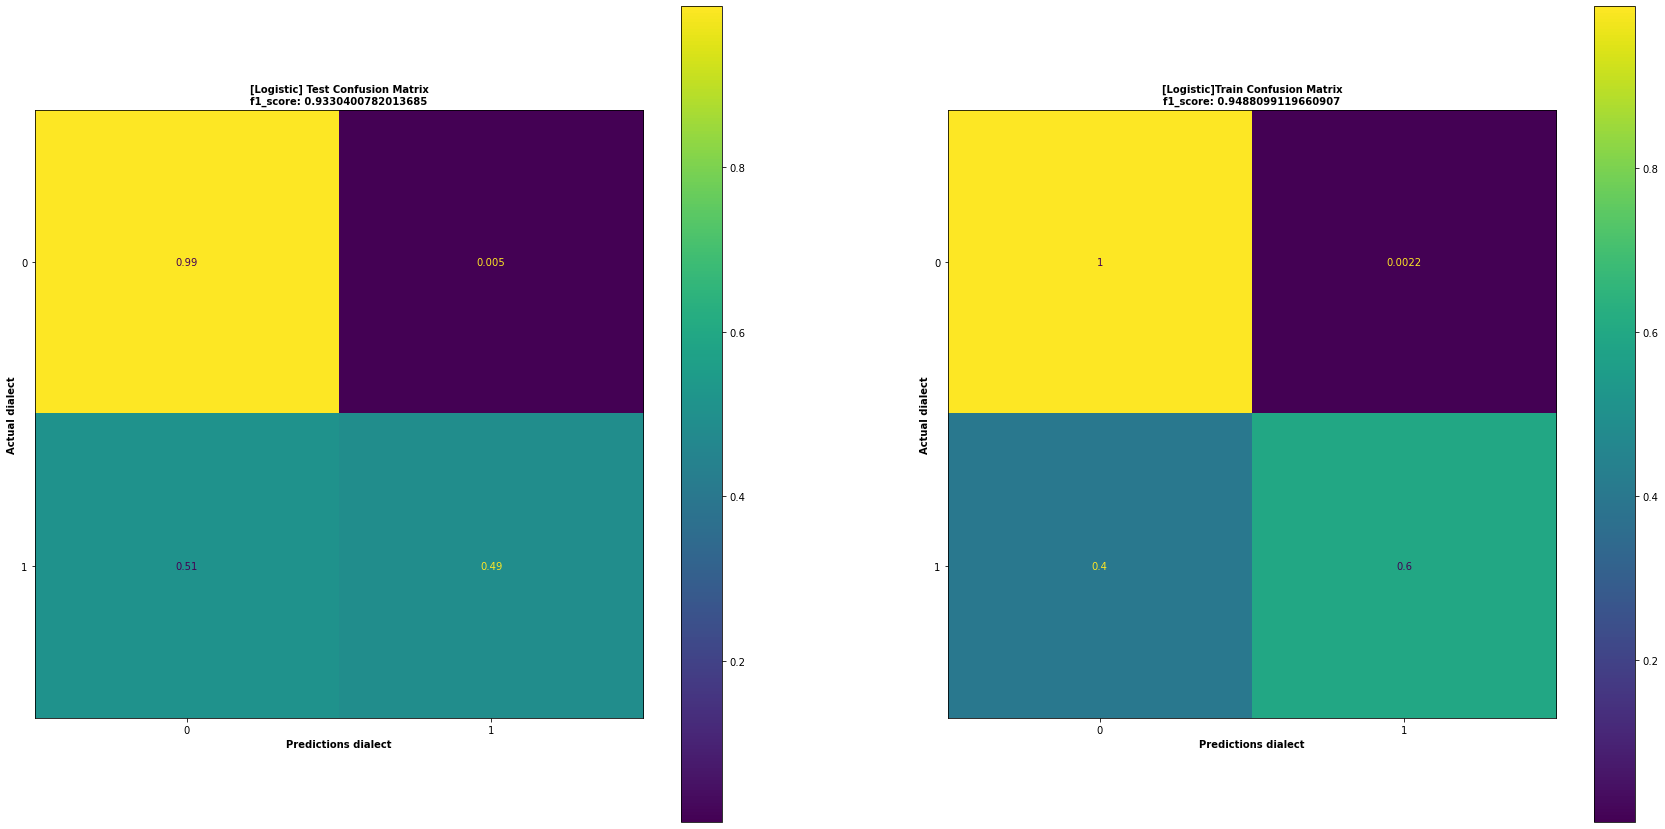

In [41]:
dialect_recognizer = LogisticRegression(penalty='l2', C=1, random_state=0, solver='liblinear')
dialect_recognizer.fit(X_train_tfidf, y_train)
y_train_pred = dialect_recognizer.predict(X_test_tfidf)
plot_saveResults(dialect_recognizer,"Logistic", X_train_tfidf, X_test_tfidf, y_train, y_test)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


In [43]:
y_pred_train = dialect_recognizer.predict(X_train_tfidf)
y_pred_test = dialect_recognizer.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)


Training accuracy: 0.9488099119660907
Testing accuracy: 0.9330400782013685
Training precision: 0.9501114847203311
Testing precision: 0.9329959585542644
Training recall: 0.9488099119660907
Testing recall: 0.9330400782013685
Training F1-score: 0.9434077700674048
Testing F1-score: 0.9237664812627612
Training AUC-ROC score: 0.7991488938867146
Testing AUC-ROC score: 0.7435233848277326


Text(0.5, 0, 'False Positive Rate')

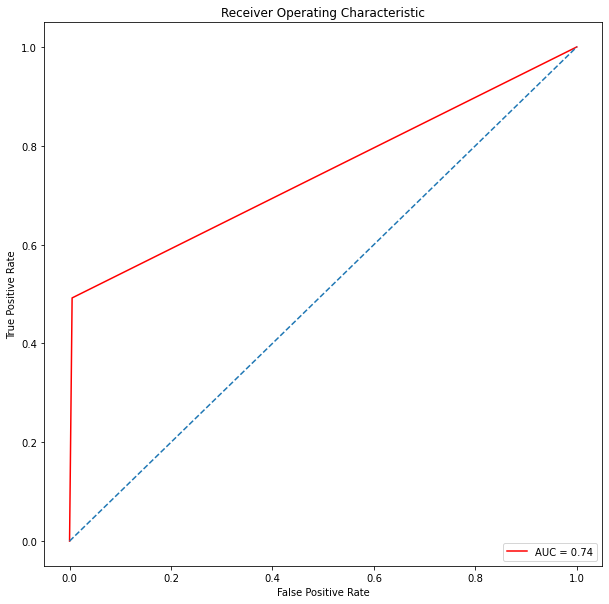

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

-------------------------- [ComplementNaiveBayes] --------------------------
Train accuracy = 0.9298989240299967
Test accuracy = 0.9188660801564027
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1794
           1       0.62      0.89      0.73       252

    accuracy                           0.92      2046
   macro avg       0.80      0.91      0.84      2046
weighted avg       0.94      0.92      0.92      2046



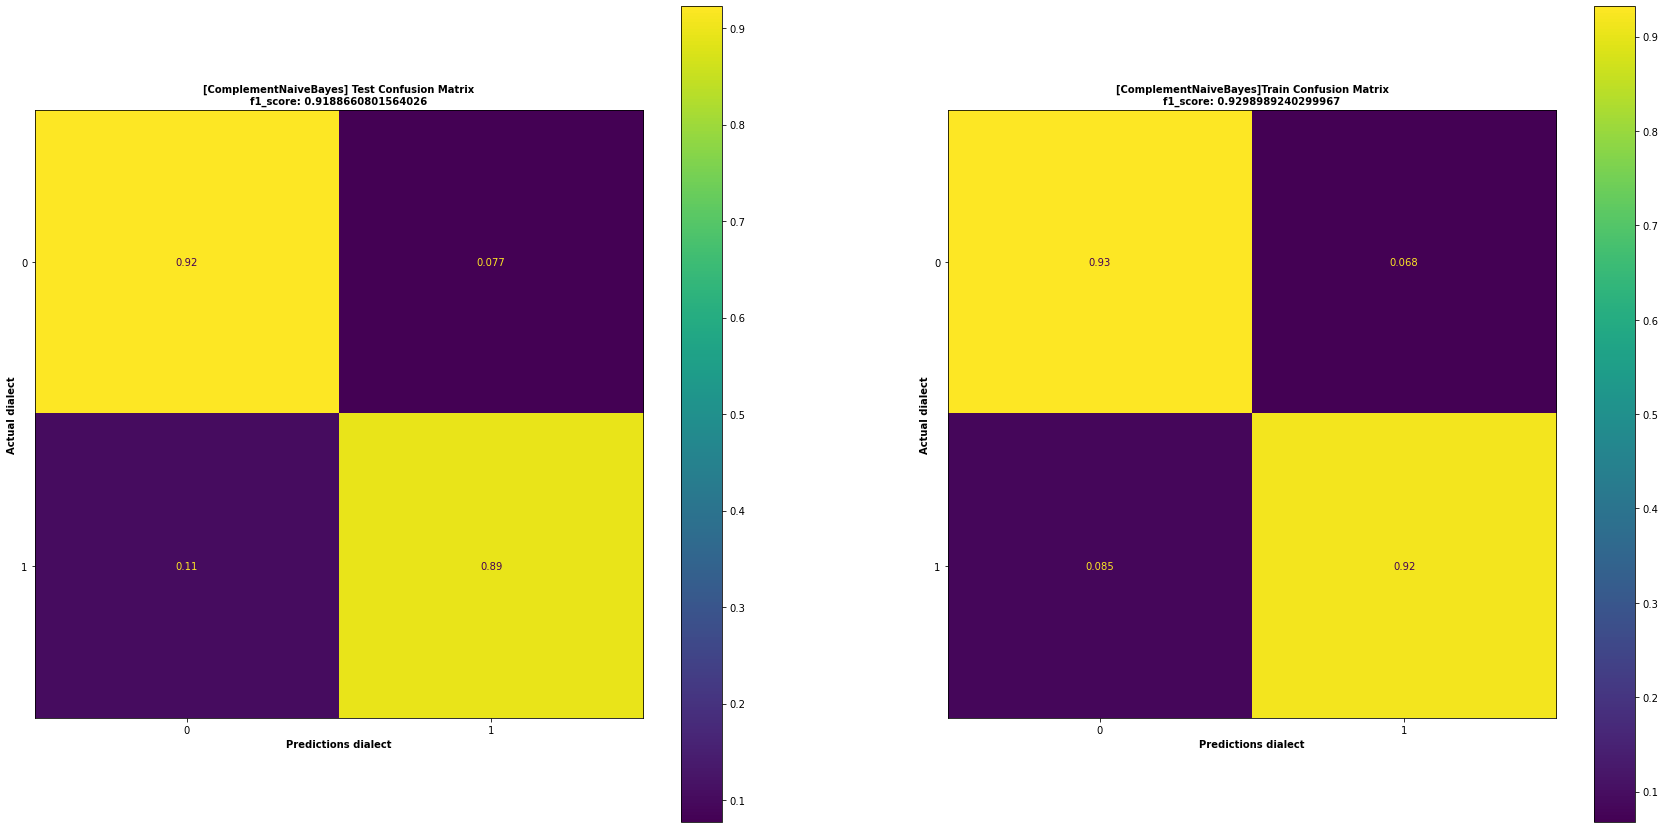

In [45]:
dialect_recognizer = ComplementNB()
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer, "ComplementNaiveBayes", X_train_tfidf, X_test_tfidf, y_train, y_test)

Training accuracy: 0.9298989240299967
Testing accuracy: 0.9188660801564027
Training precision: 0.9463098903123293
Testing precision: 0.9388911882103551
Training recall: 0.9298989240299967
Testing recall: 0.9188660801564027
Training F1-score: 0.9347216834192962
Testing F1-score: 0.92493478532307
Training AUC-ROC score: 0.923644438147971
Testing AUC-ROC score: 0.907688326166587


Text(0.5, 0, 'False Positive Rate')

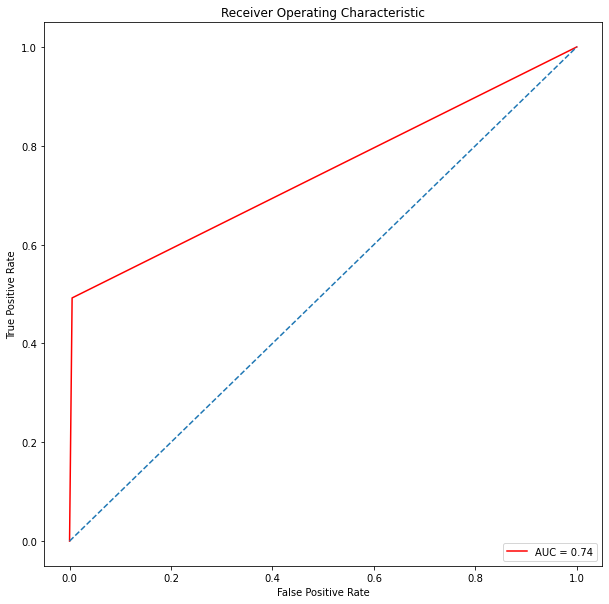

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
y_pred_train = dialect_recognizer.predict(X_train_tfidf)
y_pred_test = dialect_recognizer.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

-------------------------- [SGDClassifier] --------------------------
Train accuracy = 0.9706553635474405
Test accuracy = 0.9481915933528837
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1794
           1       0.91      0.64      0.75       252

    accuracy                           0.95      2046
   macro avg       0.93      0.82      0.86      2046
weighted avg       0.95      0.95      0.94      2046



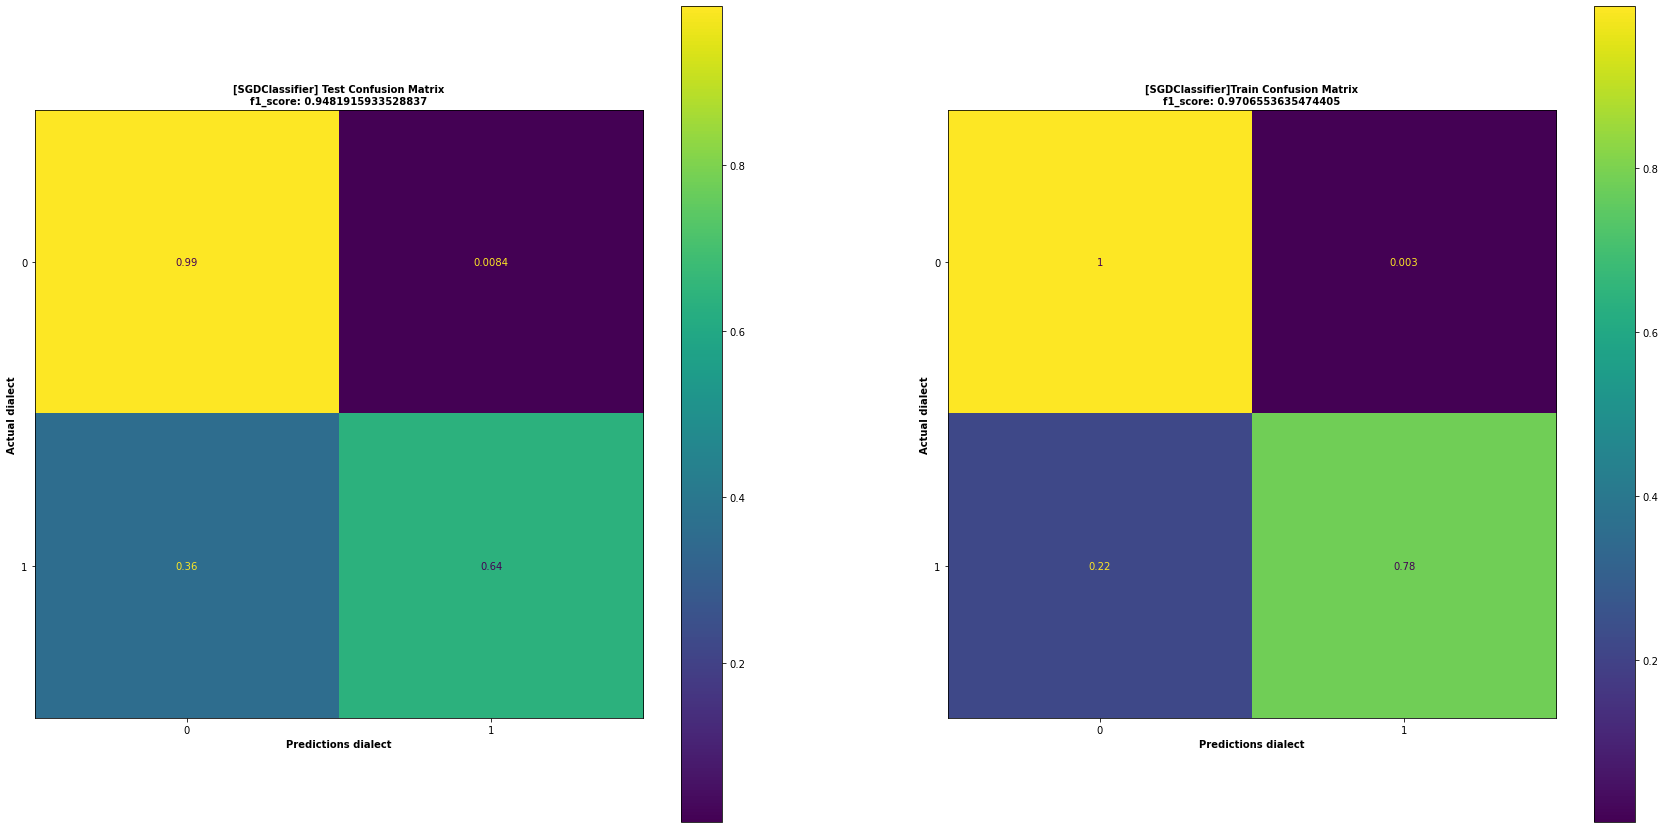

In [47]:
dialect_recognizer = SGDClassifier(loss='log', n_jobs=-1)
dialect_recognizer.fit(X_train_tfidf, y_train)
# hinge loss
plot_saveResults(dialect_recognizer, "SGDClassifier", X_train_tfidf, X_test_tfidf, y_train, y_test)

Training accuracy: 0.9706553635474405
Testing accuracy: 0.9481915933528837
Training precision: 0.970736483589582
Testing precision: 0.9468333934480216
Training recall: 0.9706553635474405
Testing recall: 0.9481915933528837
Training F1-score: 0.9692624998649498
Testing F1-score: 0.944129095808844
Training AUC-ROC score: 0.8900468496972773
Testing AUC-ROC score: 0.8152638424377554


Text(0.5, 0, 'False Positive Rate')

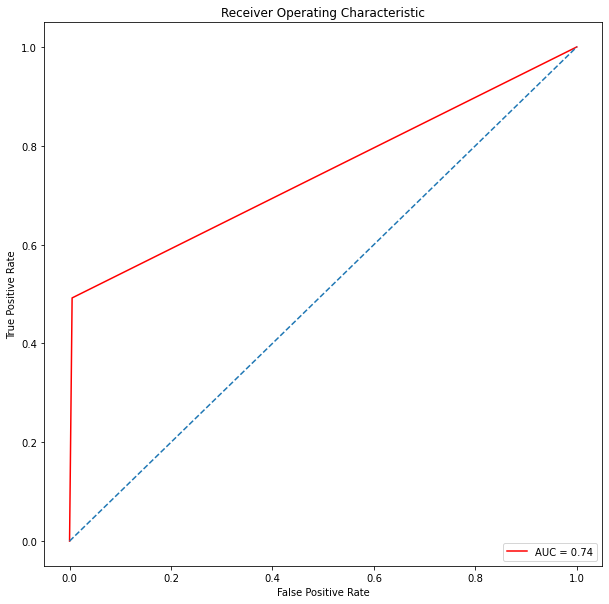

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
y_pred_train = dialect_recognizer.predict(X_train_tfidf)
y_pred_test = dialect_recognizer.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

-------------------------- [Gradient Boosting Classifier] --------------------------
Train accuracy = 0.9582654059341376
Test accuracy = 0.9310850439882697
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1794
           1       0.96      0.46      0.62       252

    accuracy                           0.93      2046
   macro avg       0.94      0.73      0.79      2046
weighted avg       0.93      0.93      0.92      2046



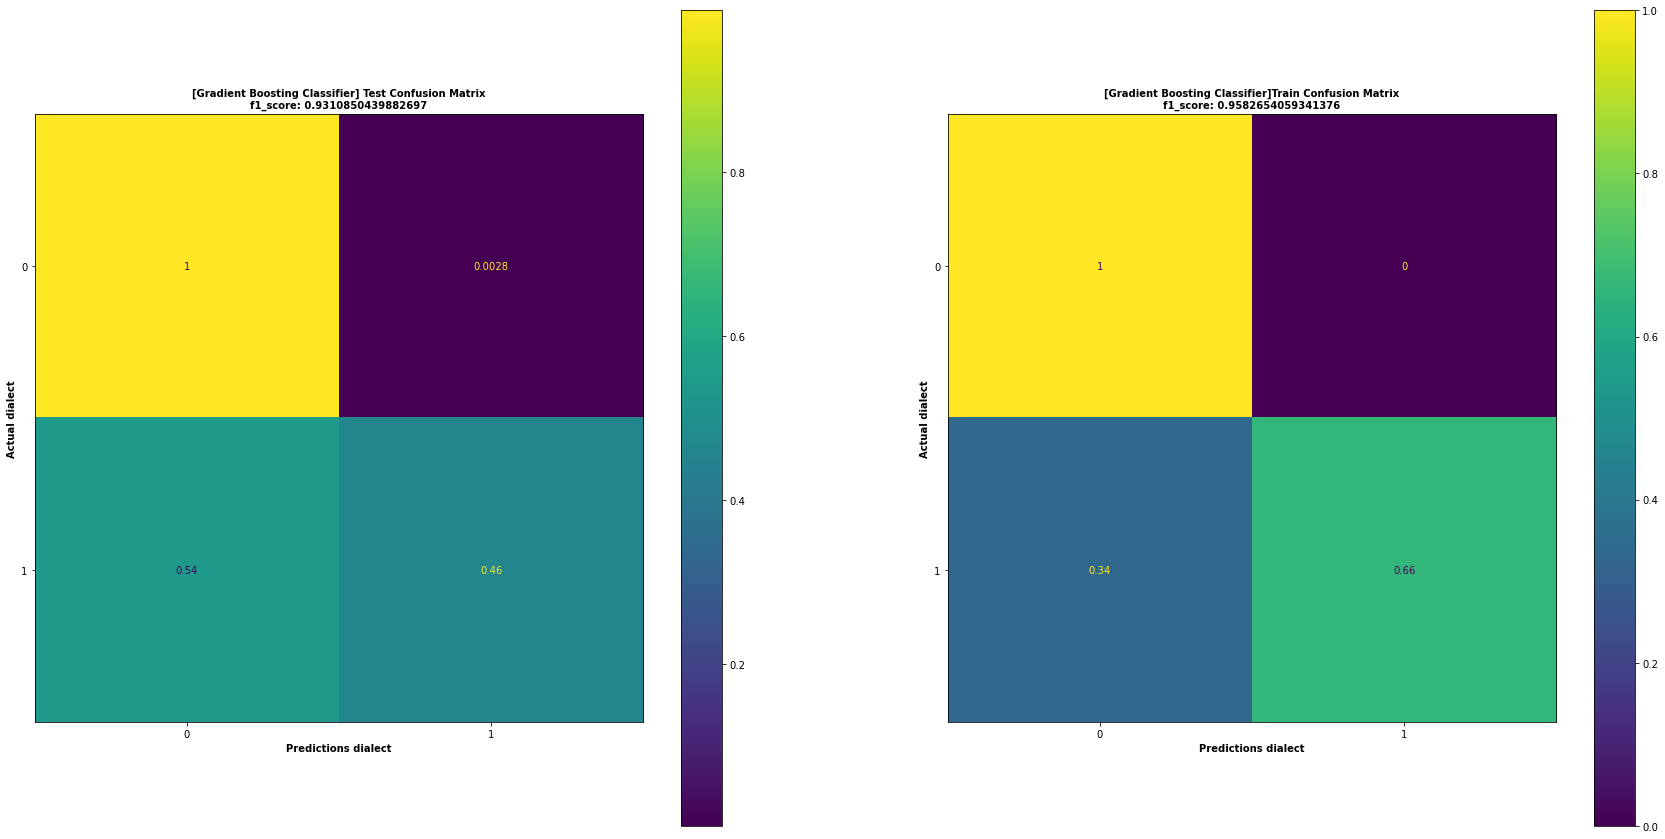

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier()

# Fit the model
gb_classifier.fit(X_train_tfidf, y_train)

# Plot and save results
plot_saveResults(gb_classifier, "Gradient Boosting Classifier", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9706553635474405
Testing accuracy: 0.9481915933528837
Training precision: 0.970736483589582
Testing precision: 0.9468333934480216
Training recall: 0.9706553635474405
Testing recall: 0.9481915933528837
Training F1-score: 0.9692624998649498
Testing F1-score: 0.944129095808844
Training AUC-ROC score: 0.8900468496972773
Testing AUC-ROC score: 0.8152638424377554


Text(0.5, 0, 'False Positive Rate')

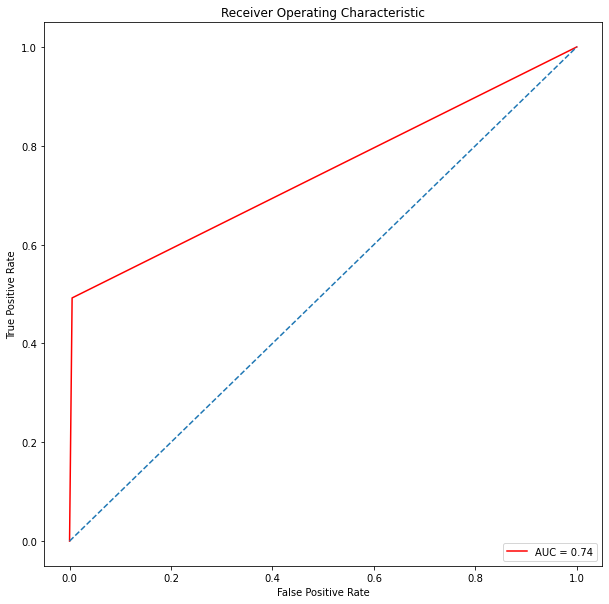

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = dialect_recognizer.predict(X_train_tfidf)
y_pred_test = dialect_recognizer.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

-------------------------- [Decision Tree] --------------------------
Train accuracy = 0.9931529181610694
Test accuracy = 0.9310850439882697
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1794
           1       0.75      0.66      0.70       252

    accuracy                           0.93      2046
   macro avg       0.85      0.81      0.83      2046
weighted avg       0.93      0.93      0.93      2046



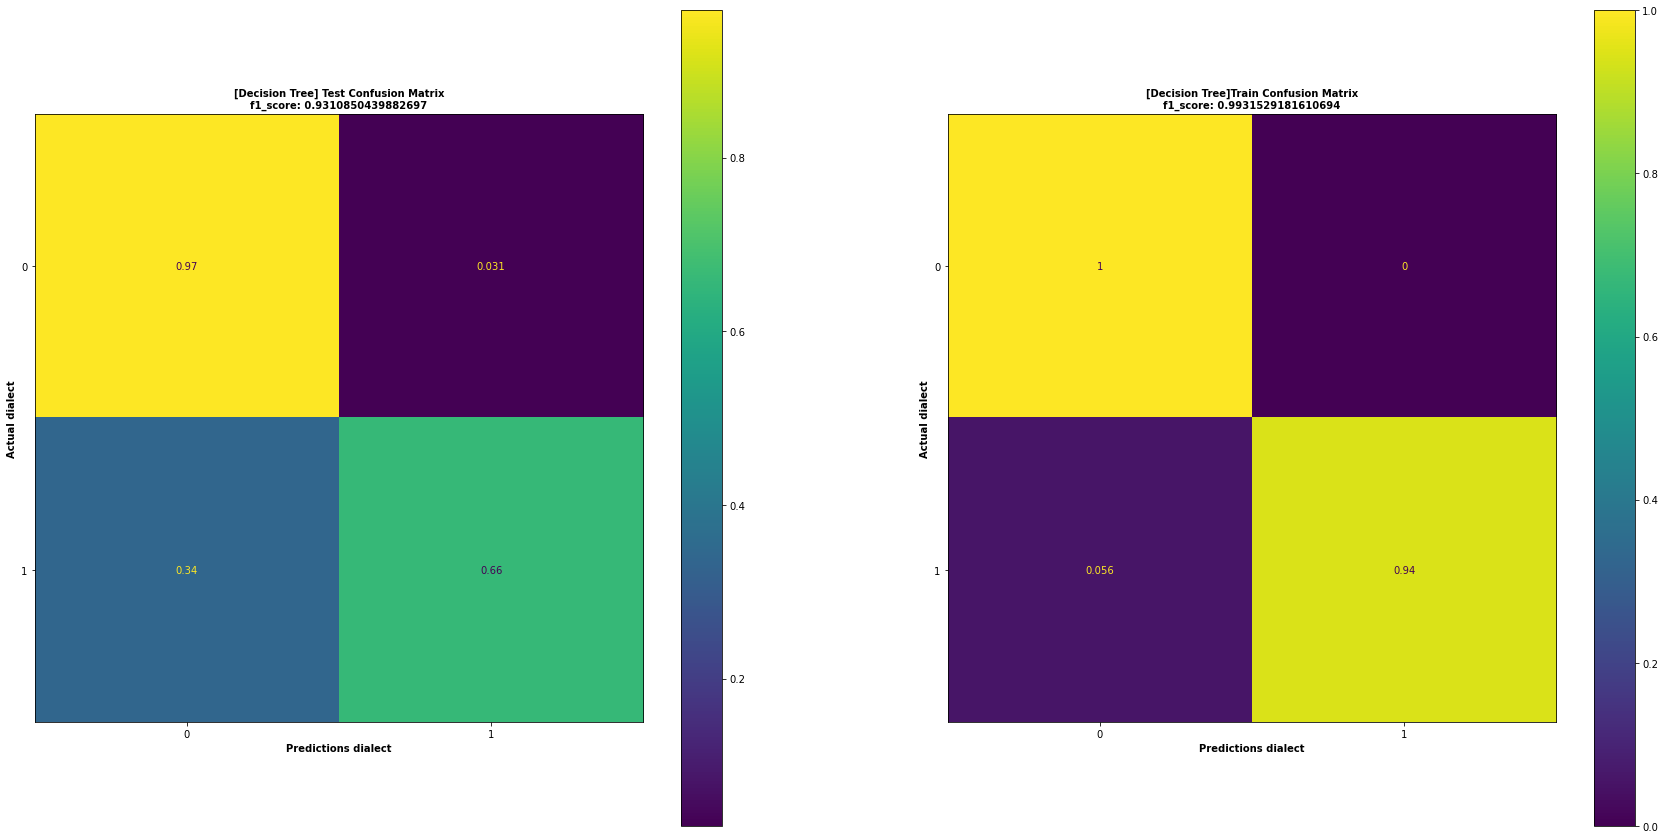

In [52]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier()

# Fit the model
dt_classifier.fit(X_train_tfidf, y_train)

# Plot and save results
plot_saveResults(dt_classifier, "Decision Tree", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9706553635474405
Testing accuracy: 0.9481915933528837
Training precision: 0.970736483589582
Testing precision: 0.9468333934480216
Training recall: 0.9706553635474405
Testing recall: 0.9481915933528837
Training F1-score: 0.9692624998649498
Testing F1-score: 0.944129095808844
Training AUC-ROC score: 0.8900468496972773
Testing AUC-ROC score: 0.8152638424377554


Text(0.5, 0, 'False Positive Rate')

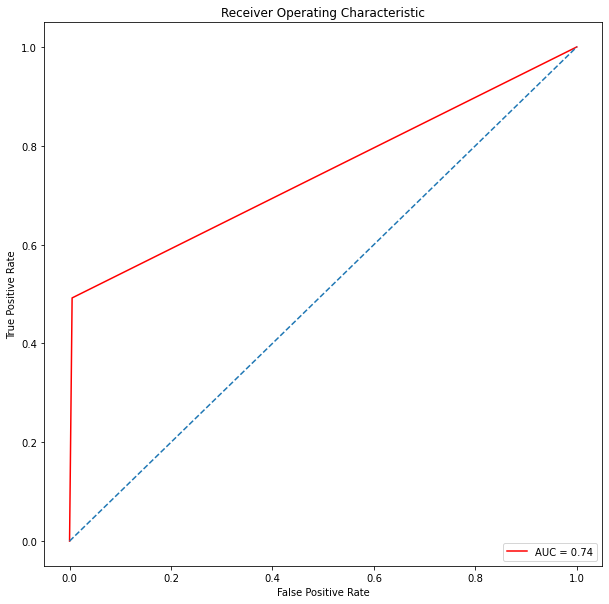

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = dialect_recognizer.predict(X_train_tfidf)
y_pred_test = dialect_recognizer.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [55]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

dialect_recognizer = SGDClassifier(loss='hinge', n_jobs=-1)
dialect_recognizer.fit(X_train_tfidf, y_train)

y_pred_train = dialect_recognizer.predict(X_train_tfidf)
y_pred_test = dialect_recognizer.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)


Training accuracy: 0.9820671666123247
Testing accuracy: 0.9496578690127078
Training precision: 0.9821676298208062
Testing precision: 0.9474601061473074
Training recall: 0.9820671666123247
Testing recall: 0.9496578690127078
Training F1-score: 0.9815504593156136
Testing F1-score: 0.9472862596440164
Training AUC-ROC score: 0.9317959116211254
Testing AUC-ROC score: 0.8416812655943091


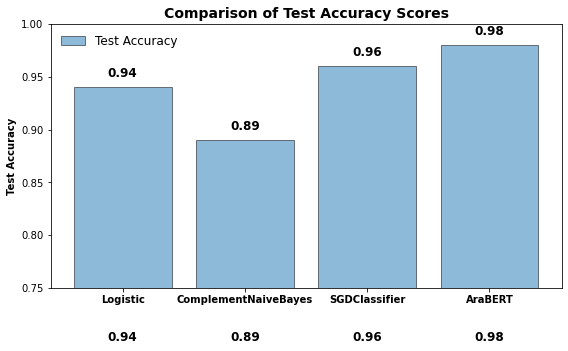

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Define the model names and test accuracy scores
model_names = ['Logistic', 'ComplementNaiveBayes', 'SGDClassifier', 'AraBERT']
test_acc_scores = [0.94, 0.89, 0.96, 0.98]

# Set up the bar chart
fig, ax = plt.subplots(figsize=(8, 5))
x_pos = np.arange(len(model_names))
rects = ax.bar(x_pos, test_acc_scores, align='center', alpha=0.5, edgecolor='black')

# Set the chart title, axis labels, and ticks
ax.set_title('Comparison of Test Accuracy Scores', fontweight='bold', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontweight='bold')
ax.set_ylabel('Test Accuracy', fontweight='bold')
ax.set_ylim([0.75, 1.0])

# Add data labels to the bars
for i, v in enumerate(test_acc_scores):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold', fontsize=12)

# Display the test accuracy values outside of the plot
for i, v in enumerate(test_acc_scores):
    ax.text(i, 0.7, f"{v:.2f}", ha='center', fontweight='bold', fontsize=12)

# Add a legend and format the plot area
ax.legend([f'Test Accuracy'], frameon=False, fontsize=12)
plt.tight_layout()

# Display the chart
plt.show()


# Addition models>>

Support Vector Machine

-------------------------- [Support Vector Machine] --------------------------
Train accuracy = 0.9735898271926965
Test accuracy = 0.9525904203323559
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1794
           1       0.89      0.70      0.78       252

    accuracy                           0.95      2046
   macro avg       0.93      0.84      0.88      2046
weighted avg       0.95      0.95      0.95      2046



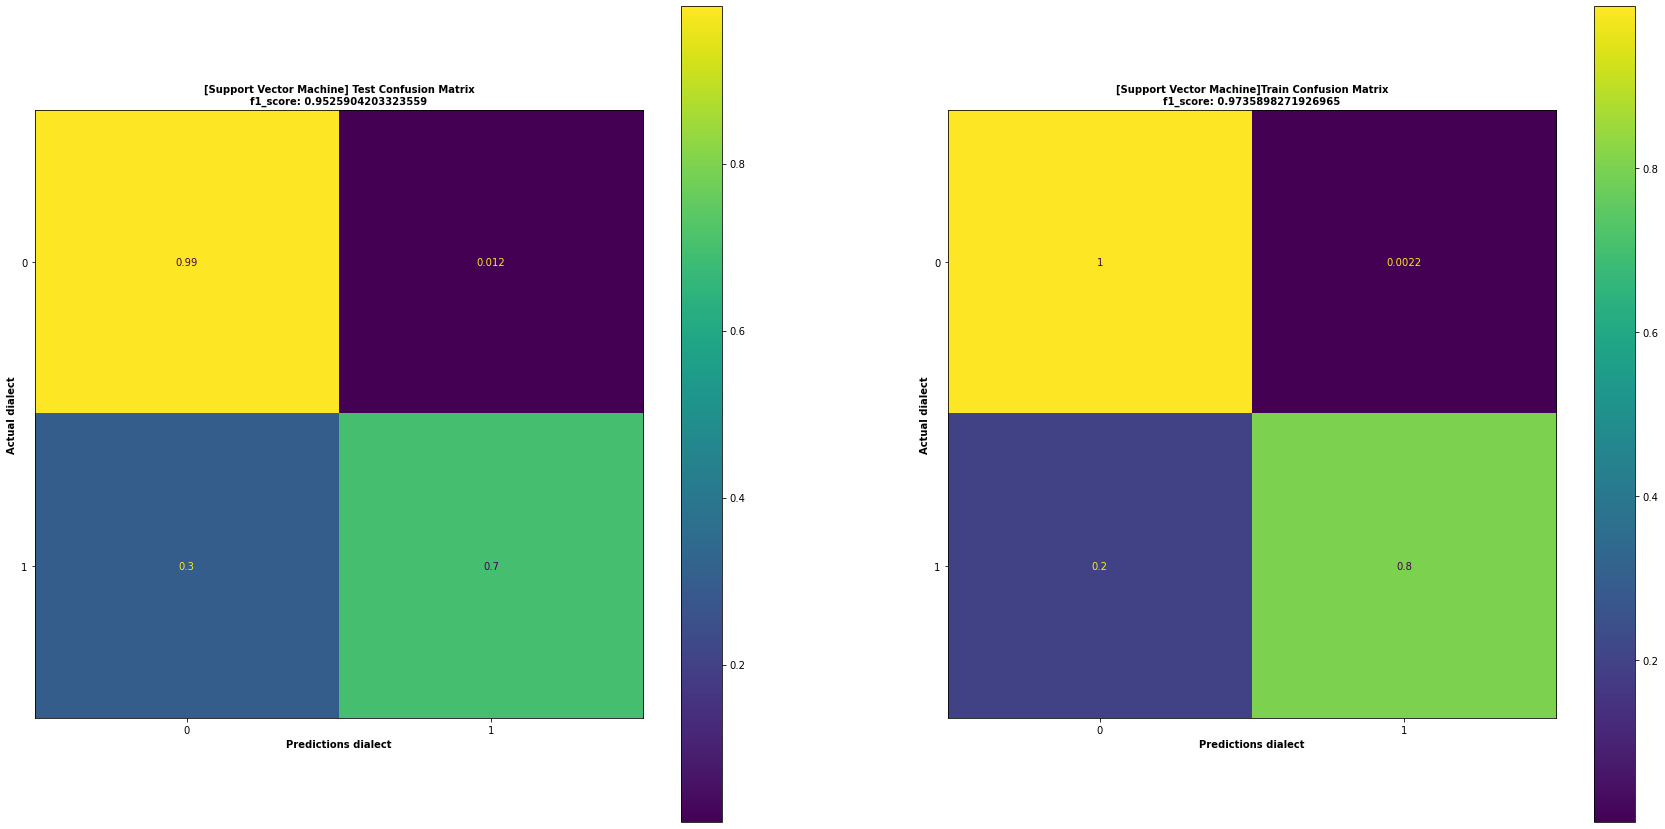

In [57]:
from sklearn.svm import SVC

# Create the SVM classifier object
svm_classifier = SVC(kernel='linear')

# Fit the model on the training data
svm_classifier.fit(X_train_tfidf, y_train)

# Plot and save the results
plot_saveResults(svm_classifier, "Support Vector Machine", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9820671666123247
Testing accuracy: 0.9496578690127078
Training precision: 0.9821676298208062
Testing precision: 0.9474601061473074
Training recall: 0.9820671666123247
Testing recall: 0.9496578690127078
Training F1-score: 0.9815504593156136
Testing F1-score: 0.9472862596440164
Training AUC-ROC score: 0.9317959116211254
Testing AUC-ROC score: 0.8416812655943091


Text(0.5, 0, 'False Positive Rate')

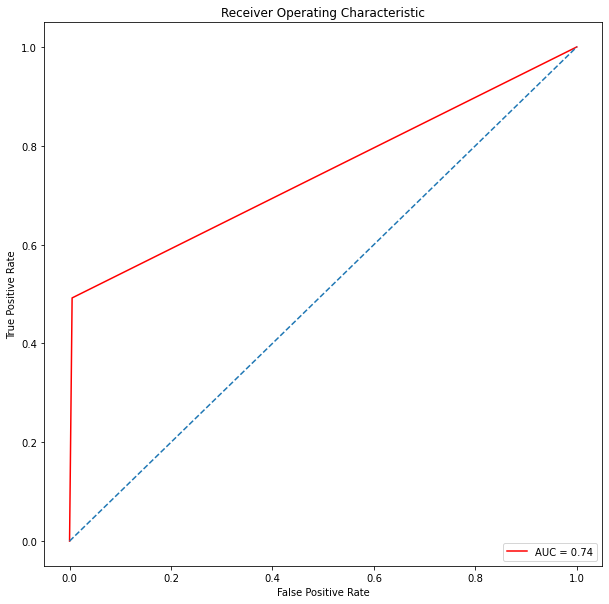

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = dialect_recognizer.predict(X_train_tfidf)
y_pred_test = dialect_recognizer.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

K-Nearest Neighbors

-------------------------- [K-Nearest Neighbors] --------------------------
Train accuracy = 0.9468536028692534
Test accuracy = 0.9125122189638318
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1794
           1       0.83      0.37      0.51       252

    accuracy                           0.91      2046
   macro avg       0.87      0.68      0.73      2046
weighted avg       0.91      0.91      0.90      2046



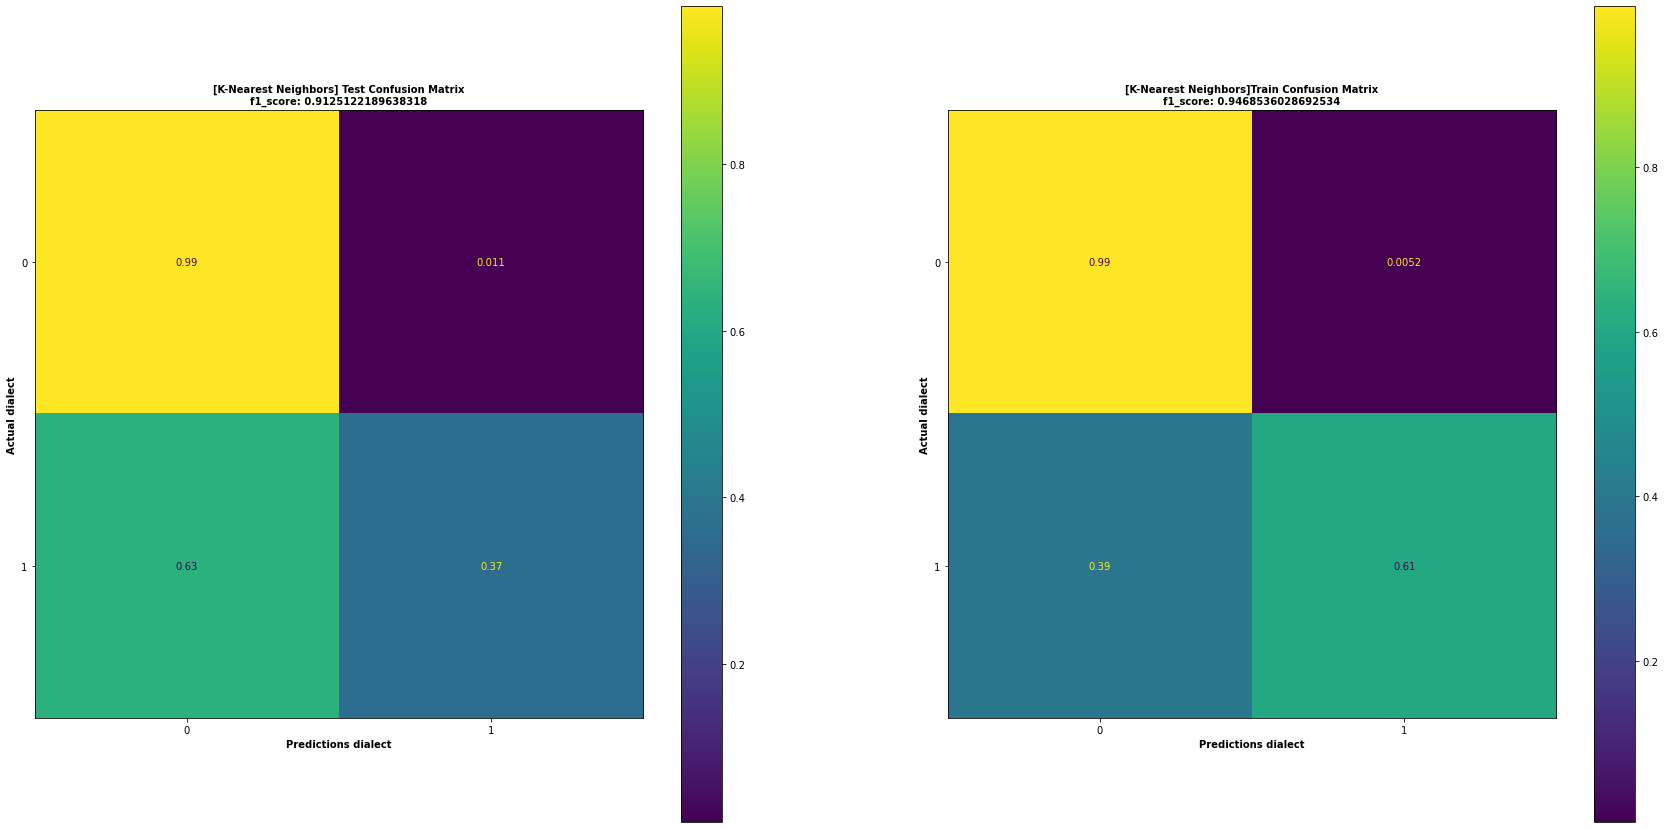

In [59]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNN classifier object
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Fit the model on the training data
knn_classifier.fit(X_train_tfidf, y_train)

# Plot and save the results
plot_saveResults(knn_classifier, "K-Nearest Neighbors", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9468536028692534
Testing accuracy: 0.9125122189638318
Training precision: 0.9466400709410923
Testing precision: 0.9064143595276378
Training recall: 0.9468536028692534
Testing recall: 0.9125122189638318
Training F1-score: 0.9417275337605929
Testing F1-score: 0.8971748232830233
Training AUC-ROC score: 0.8003068546951031
Testing AUC-ROC score: 0.6772442533312099


Text(0.5, 0, 'False Positive Rate')

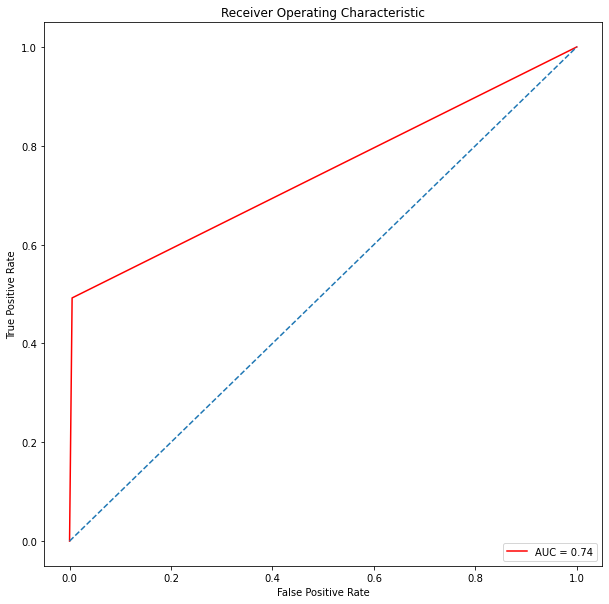

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = knn_classifier.predict(X_train_tfidf)
y_pred_test = knn_classifier.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Multinomial Naive Bayes

-------------------------- [Multinomial Naive Bayes] --------------------------
Train accuracy = 0.9621780241278122
Test accuracy = 0.9521016617790812
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1794
           1       0.96      0.64      0.77       252

    accuracy                           0.95      2046
   macro avg       0.95      0.82      0.87      2046
weighted avg       0.95      0.95      0.95      2046



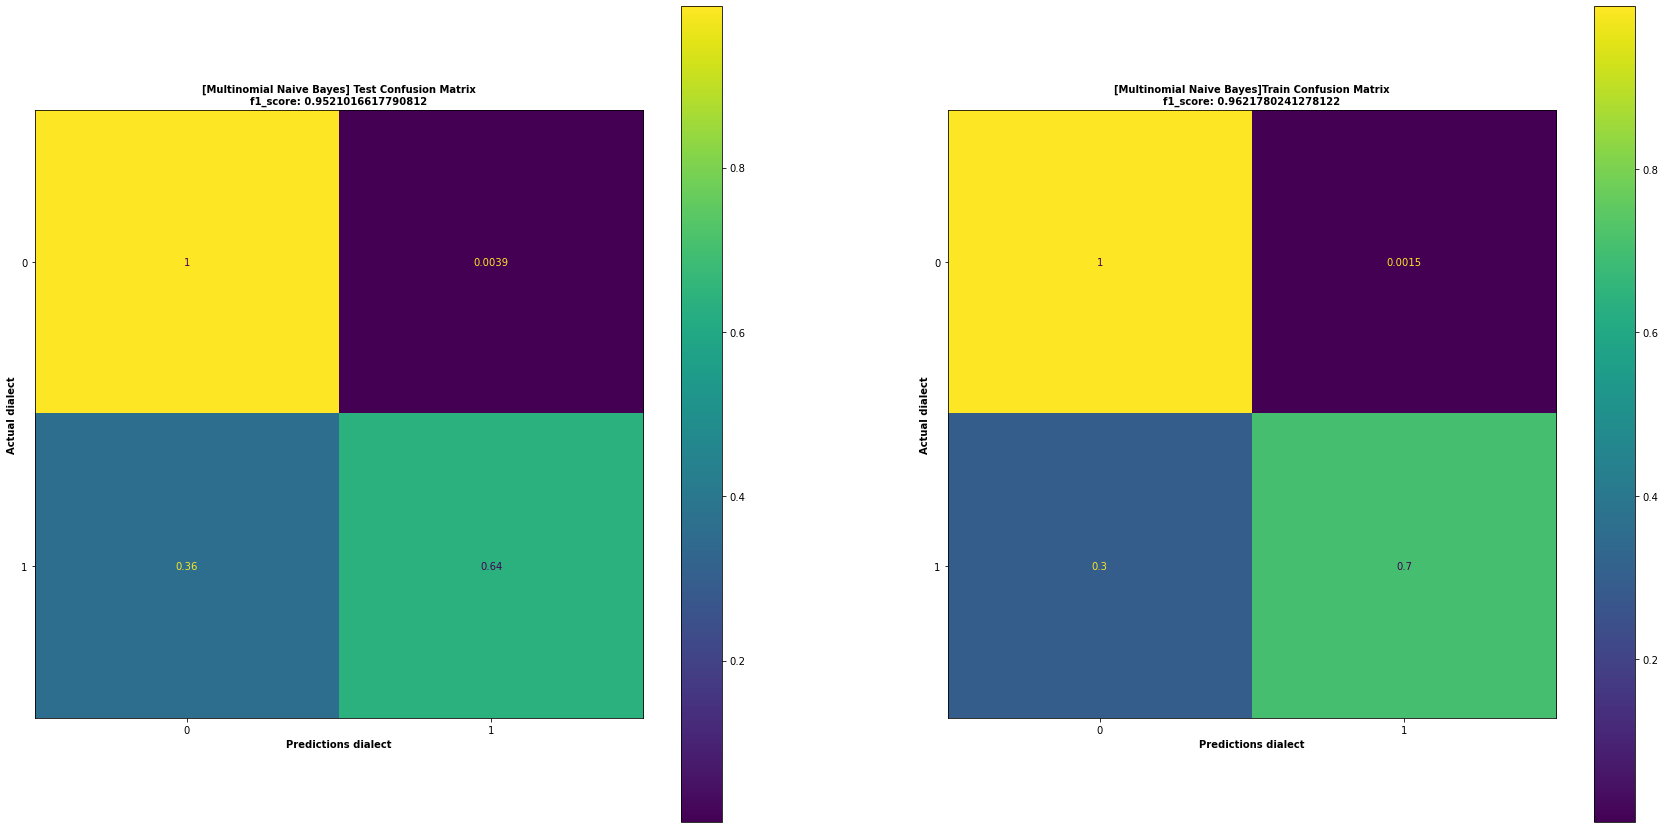

In [65]:
from sklearn.naive_bayes import MultinomialNB

# Create the Multinomial Naive Bayes classifier object
nb_classifier = MultinomialNB()

# Fit the model on the training data
nb_classifier.fit(X_train_tfidf, y_train)

# Plot and save the results
plot_saveResults(nb_classifier, "Multinomial Naive Bayes", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9621780241278122
Testing accuracy: 0.9521016617790812
Training precision: 0.9630663950231273
Testing precision: 0.9523803946920508
Training recall: 0.9621780241278122
Testing recall: 0.9521016617790812
Training F1-score: 0.959398483489982
Testing F1-score: 0.9478596847667058
Training AUC-ROC score: 0.8511080809332948
Testing AUC-ROC score: 0.8174934968413229


Text(0.5, 0, 'False Positive Rate')

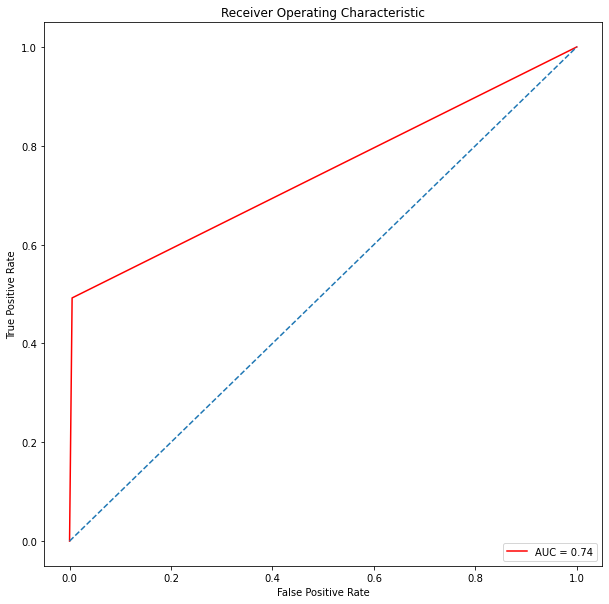

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = nb_classifier.predict(X_train_tfidf)
y_pred_test = nb_classifier.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

-------------------------- [Decision Tree] --------------------------
Train accuracy = 0.9931529181610694
Test accuracy = 0.9257086999022482
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1794
           1       0.72      0.64      0.68       252

    accuracy                           0.93      2046
   macro avg       0.84      0.80      0.82      2046
weighted avg       0.92      0.93      0.92      2046



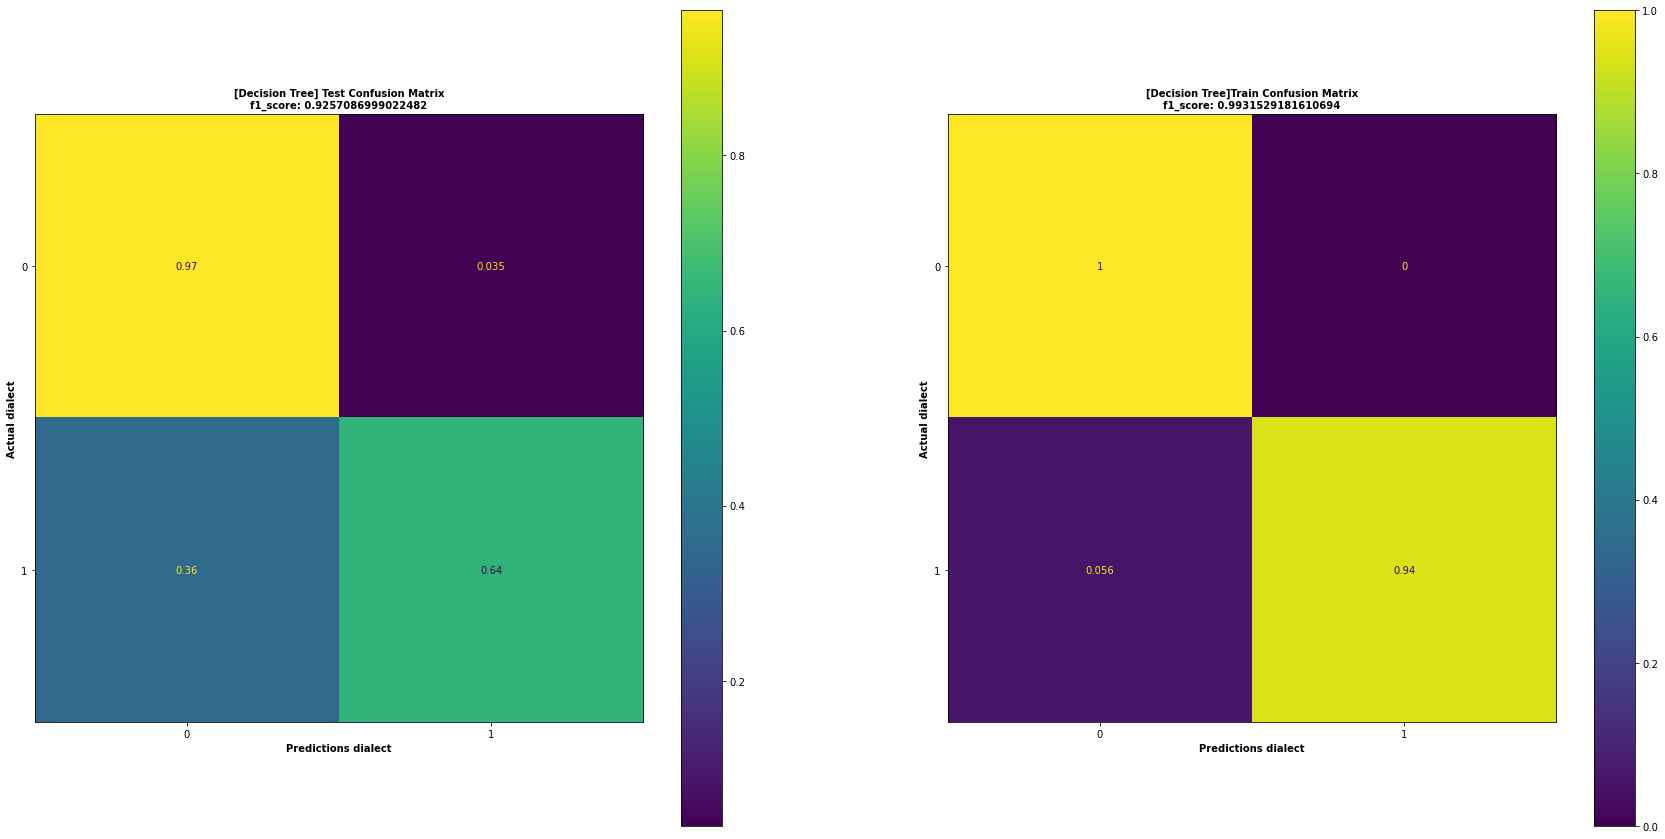

In [67]:
from sklearn.tree import DecisionTreeClassifier

# Create the Decision Tree classifier object
dt_classifier = DecisionTreeClassifier()

# Fit the model on the training data
dt_classifier.fit(X_train_tfidf, y_train)

# Plot and save the results
plot_saveResults(dt_classifier, "Decision Tree", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9931529181610694
Testing accuracy: 0.9257086999022482
Training precision: 0.9932059767288249
Testing precision: 0.922596820869722
Training recall: 0.9931529181610694
Testing recall: 0.9257086999022482
Training F1-score: 0.9930684189424396
Testing F1-score: 0.9238112939100329
Training AUC-ROC score: 0.9722222222222222
Testing AUC-ROC score: 0.8041487498009237


Text(0.5, 0, 'False Positive Rate')

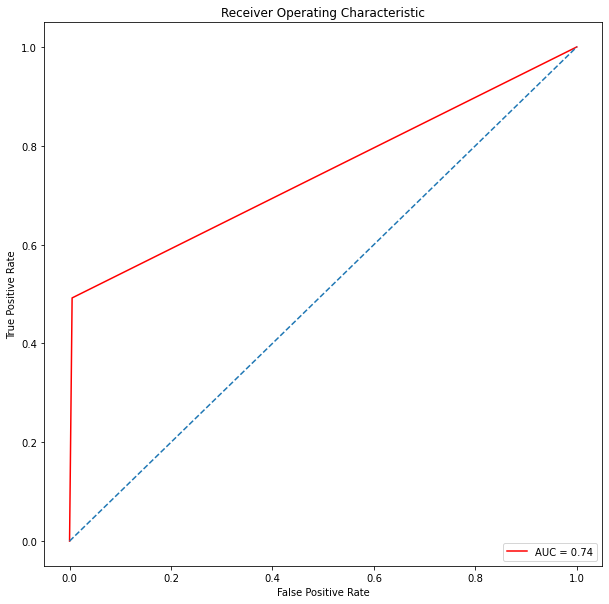

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = dt_classifier.predict(X_train_tfidf)
y_pred_test = dt_classifier.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Random Forest

-------------------------- [Random Forest] --------------------------
Train accuracy = 0.9931529181610694
Test accuracy = 0.946236559139785
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1794
           1       0.89      0.64      0.75       252

    accuracy                           0.95      2046
   macro avg       0.92      0.81      0.86      2046
weighted avg       0.94      0.95      0.94      2046



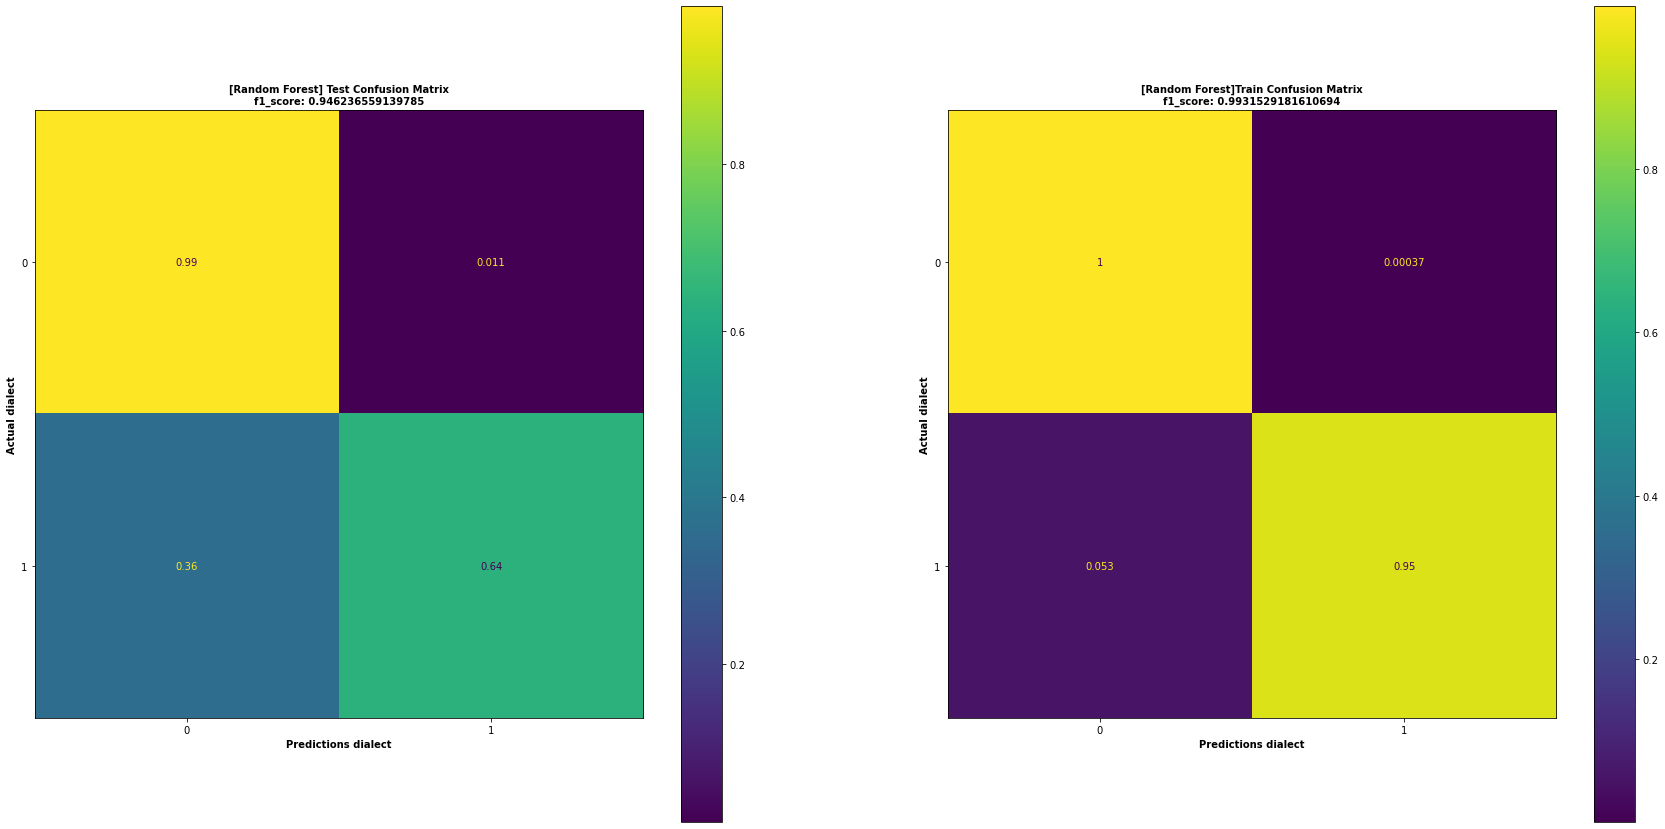

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest classifier object
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train_tfidf, y_train)

# Plot and save the results
plot_saveResults(rf_classifier, "Random Forest", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9931529181610694
Testing accuracy: 0.946236559139785
Training precision: 0.9931814151196564
Testing precision: 0.9442381495695468
Training recall: 0.9931529181610694
Testing recall: 0.946236559139785
Training F1-score: 0.9930767111137827
Testing F1-score: 0.9422850931312062
Training AUC-ROC score: 0.9733590308153343
Testing AUC-ROC score: 0.8141490152359716


Text(0.5, 0, 'False Positive Rate')

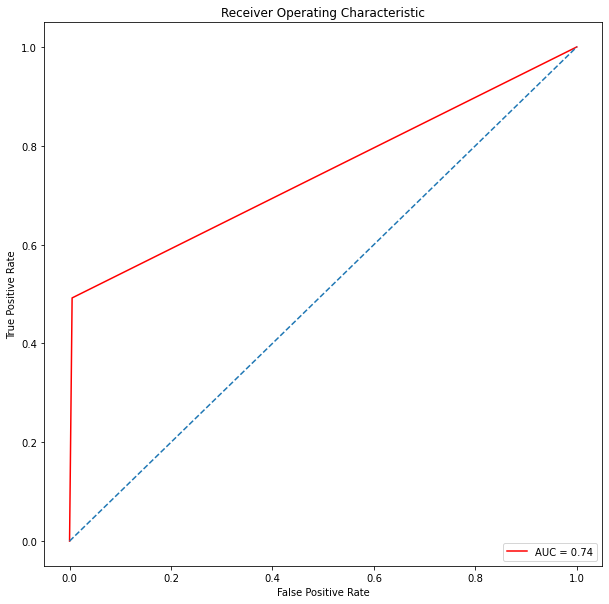

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = rf_classifier.predict(X_train_tfidf)
y_pred_test = rf_classifier.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

AdaBoost

-------------------------- [AdaBoost] --------------------------
Train accuracy = 0.9758721878056733
Test accuracy = 0.9330400782013685
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1794
           1       0.78      0.64      0.70       252

    accuracy                           0.93      2046
   macro avg       0.86      0.81      0.83      2046
weighted avg       0.93      0.93      0.93      2046



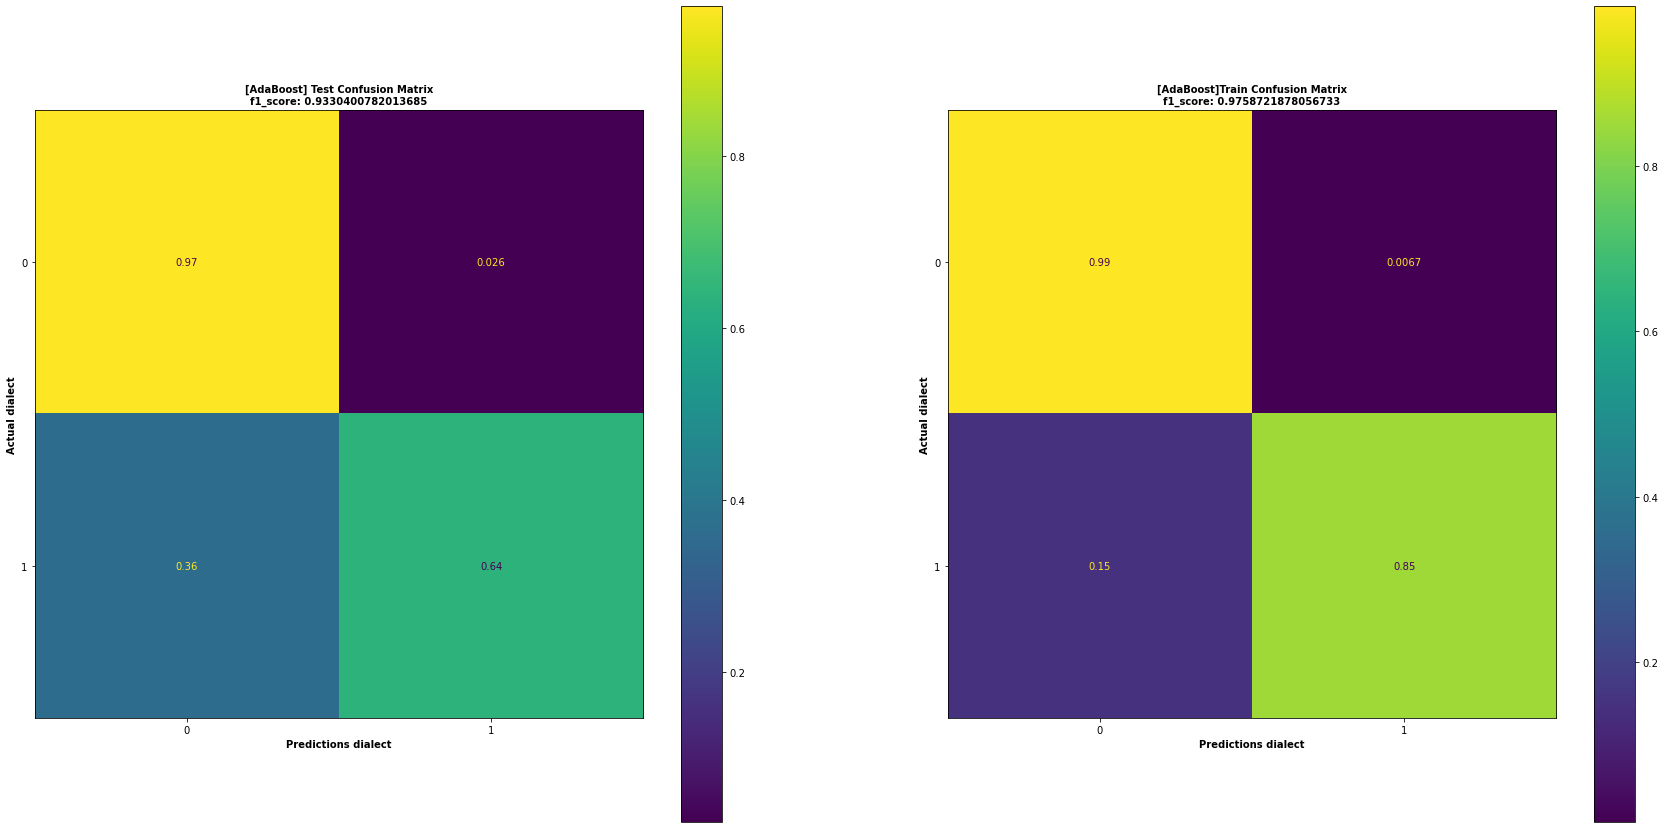

In [71]:
from sklearn.ensemble import AdaBoostClassifier

# Create the AdaBoost classifier object
ab_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
ab_classifier.fit(X_train_tfidf, y_train)

# Plot and save the results
plot_saveResults(ab_classifier, "AdaBoost", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9758721878056733
Testing accuracy: 0.9330400782013685
Training precision: 0.9754706814461215
Testing precision: 0.9292408375711012
Training recall: 0.9758721878056733
Testing recall: 0.9330400782013685
Training F1-score: 0.9753183514546753
Testing F1-score: 0.930172427205475
Training AUC-ROC score: 0.922578956792419
Testing AUC-ROC score: 0.8066239316239316


Text(0.5, 0, 'False Positive Rate')

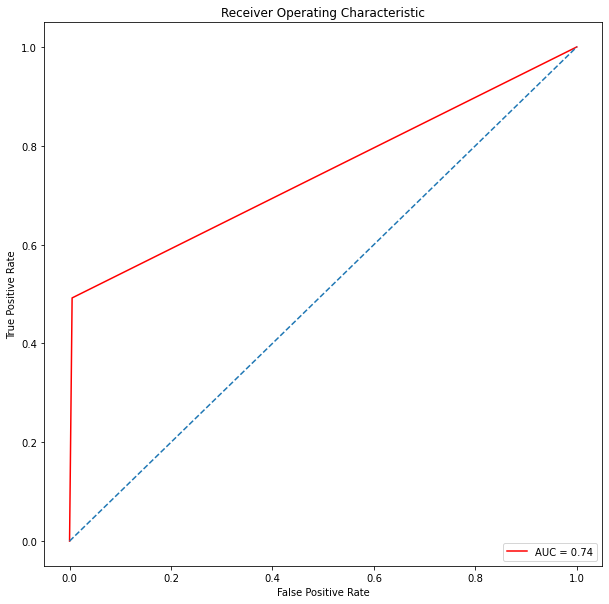

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = ab_classifier.predict(X_train_tfidf)
y_pred_test = ab_classifier.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Bagging classifier

-------------------------- [Bagging] --------------------------
Train accuracy = 0.9931529181610694
Test accuracy = 0.9384164222873901
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1794
           1       0.81      0.65      0.72       252

    accuracy                           0.94      2046
   macro avg       0.88      0.81      0.84      2046
weighted avg       0.93      0.94      0.94      2046



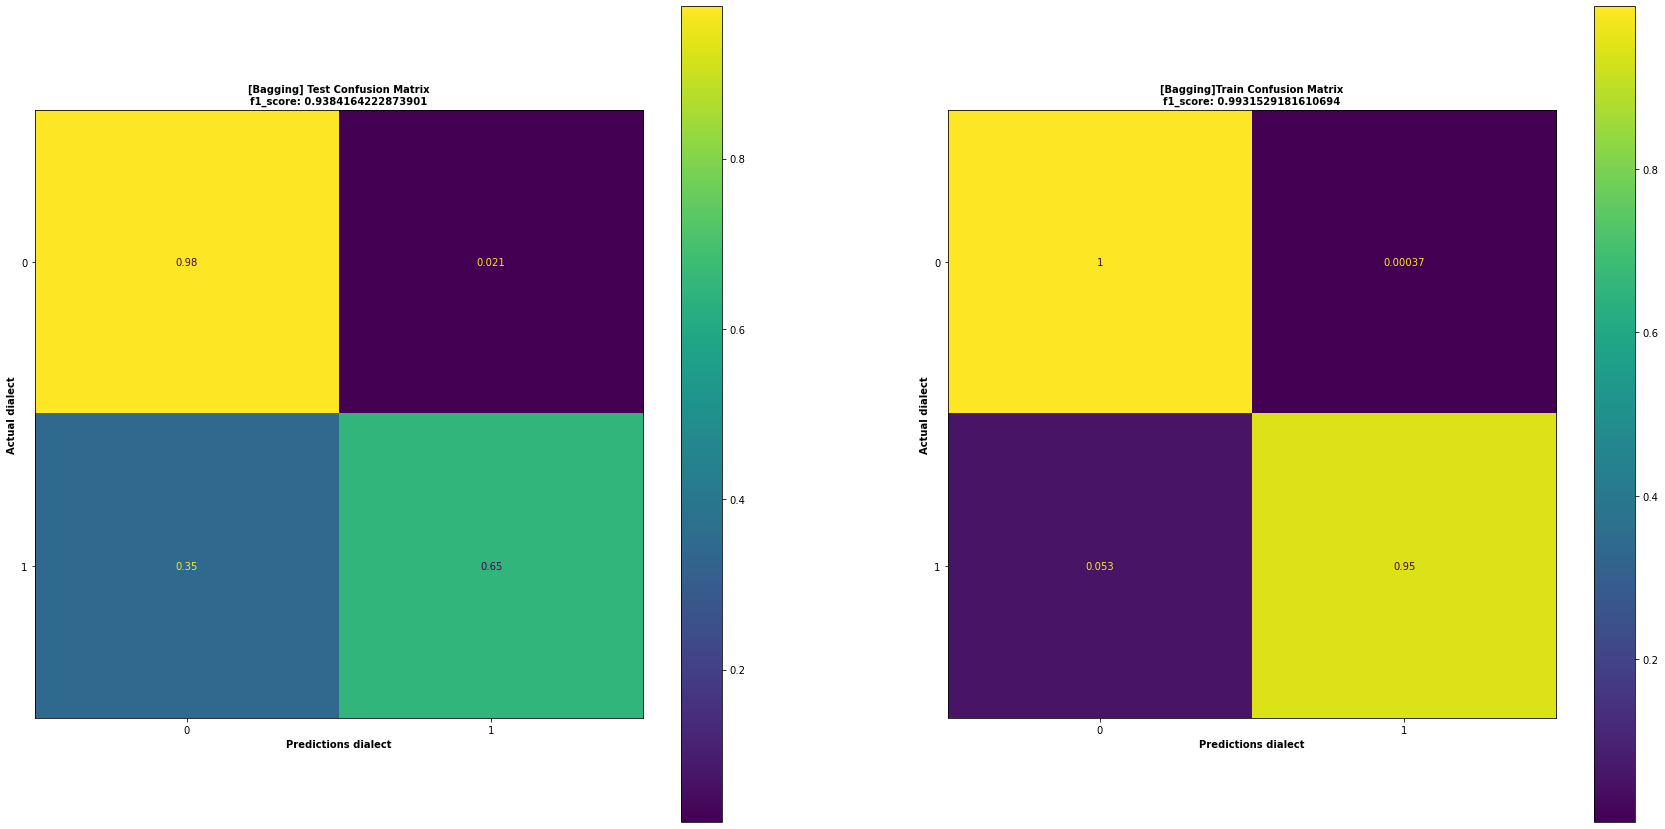

In [73]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create the base Decision Tree classifier object
base_classifier = DecisionTreeClassifier()

# Create the Bagging classifier object
bagging_classifier = BaggingClassifier(base_estimator=base_classifier, n_estimators=100, random_state=42)

# Fit the model on the training data
bagging_classifier.fit(X_train_tfidf, y_train)

# Plot and save the results
plot_saveResults(bagging_classifier, "Bagging", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9931529181610694
Testing accuracy: 0.9384164222873901
Training precision: 0.9931814151196564
Testing precision: 0.9349854235301075
Training recall: 0.9931529181610694
Testing recall: 0.9384164222873901
Training F1-score: 0.9930767111137827
Testing F1-score: 0.9354484527720661
Training AUC-ROC score: 0.9733590308153343
Testing AUC-ROC score: 0.8148059669798801


Text(0.5, 0, 'False Positive Rate')

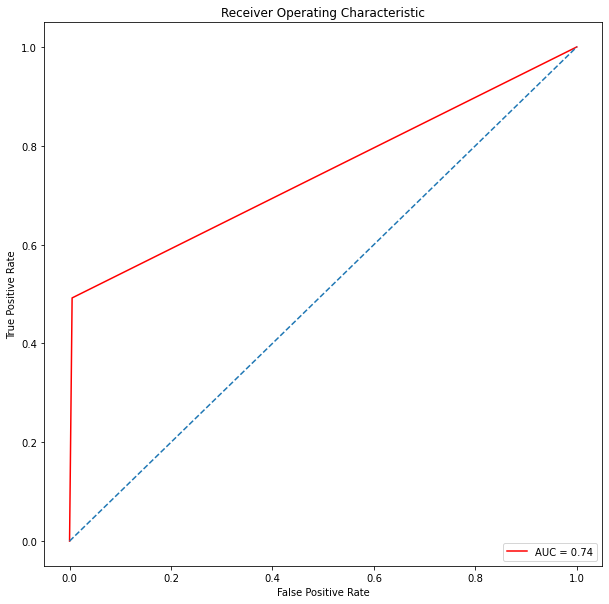

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = bagging_classifier.predict(X_train_tfidf)
y_pred_test = bagging_classifier.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Extra Trees

-------------------------- [Extra Trees] --------------------------
Train accuracy = 0.9931529181610694
Test accuracy = 0.9516129032258065
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1794
           1       0.90      0.69      0.78       252

    accuracy                           0.95      2046
   macro avg       0.93      0.84      0.88      2046
weighted avg       0.95      0.95      0.95      2046



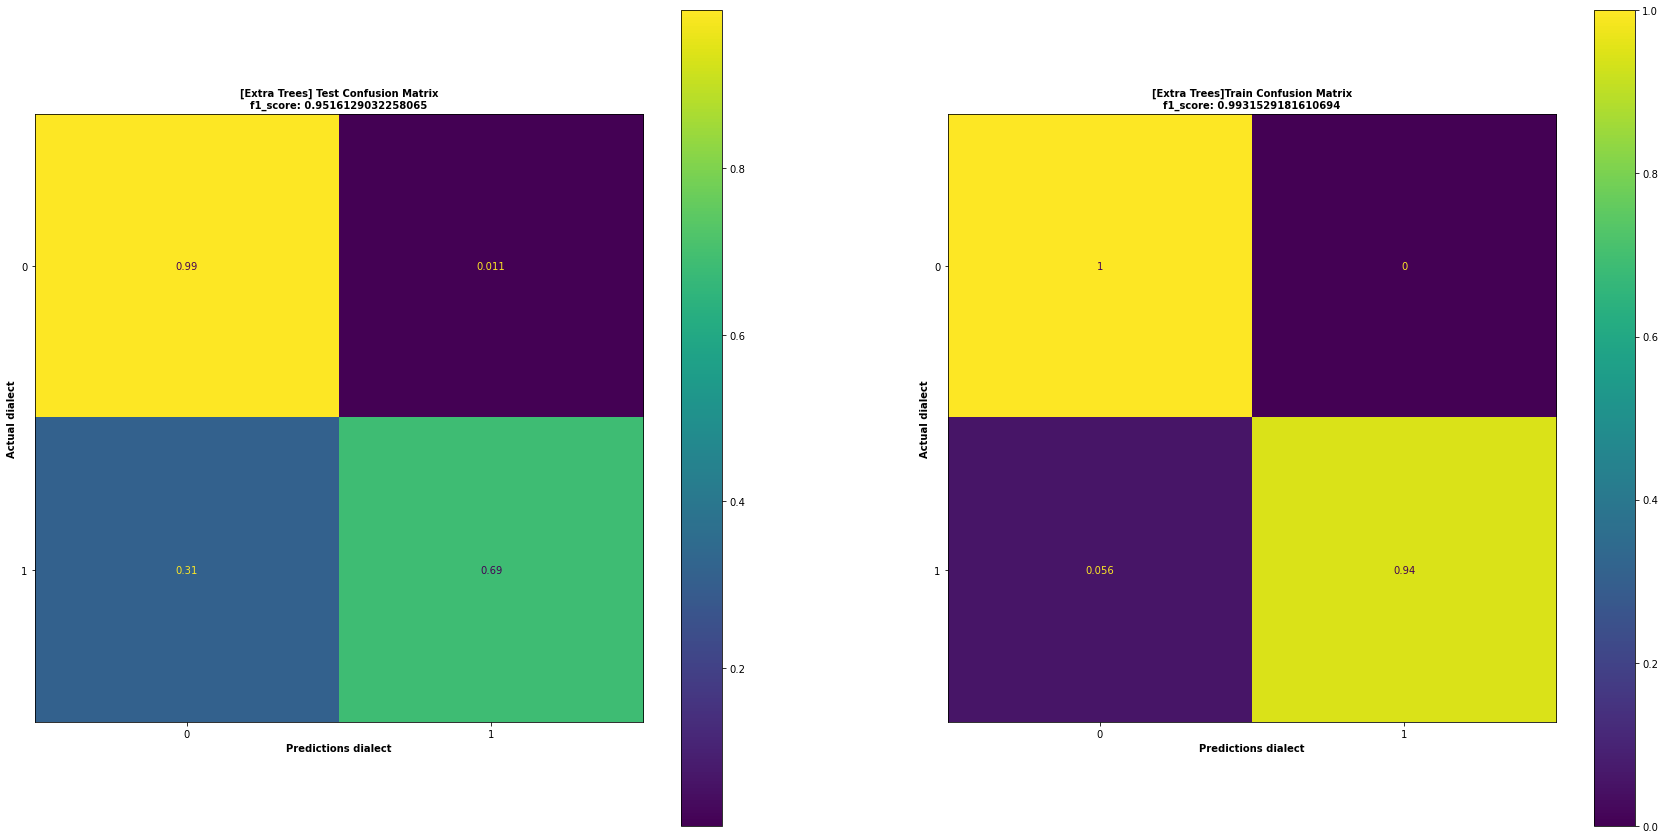

In [75]:
from sklearn.ensemble import ExtraTreesClassifier

# Create the Extra Trees classifier object
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
et_classifier.fit(X_train_tfidf, y_train)
y_train_pred = model
# Plot and save the results
plot_saveResults(et_classifier, "Extra Trees", X_train_tfidf, X_test_tfidf, y_train, y_test)


Training accuracy: 0.9931529181610694
Testing accuracy: 0.9516129032258065
Training precision: 0.9932059767288249
Testing precision: 0.9498540522125155
Training recall: 0.9931529181610694
Testing recall: 0.9516129032258065
Training F1-score: 0.9930684189424396
Testing F1-score: 0.9487966147731187
Training AUC-ROC score: 0.9722222222222222
Testing AUC-ROC score: 0.8376798322450497


Text(0.5, 0, 'False Positive Rate')

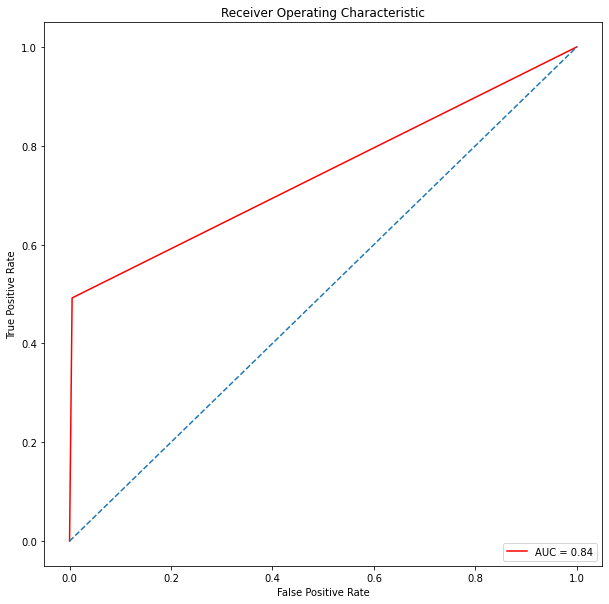

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
y_pred_train = et_classifier.predict(X_train_tfidf)
y_pred_test = et_classifier.predict(X_test_tfidf)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % test_auc_roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')